# Дмитрий Ильин
# Домашнее задание №5


В данном домашнем задании вам необходимо обучить языковую модель (не более 1B параметров) решать примеры на сложение как можно более длинных чисел.

**Ожидаемый результат**

Необходимо предоставить код, а также технический отчет, содержащий описание метода и используемых данных, оценку качества (точность сложения).

**Пояснения**

1. Можно использовать любые предобученные модели, можно их файнтюнить, обучать с нуля, адаптировать любым другим способом или брать как есть. Главное, чтобы все использованные вами идеи, код или веса моделей были описаны в приложенном отчете со ссылкой на источник.

2. Мы ожидаем, что ваш код принимает на вход два числа (в виде строк их десятичной записи) и выдает ответ в любом человекочитаемом виде. Однако, если ваша модель работает с входом в виде предложения на естественном языке, это тоже нормально, главное, чтобы это было описано в отчете.

3. Можно оценить качество работы алгоритма, посчитав accuracy на случайных множествах чисел разной длины. Если вам кажется более подходящей другая метрика, мы примем ваше решение. Опишите вашу метрику и аргументируйте выбор в отчете.

**Подсказка**

В качестве ориентира можете использовать следующий репозиторий (https://github.com/liutiedong/goat). В нём реализовано сборка датасета для обучения и само обучение.

### Разбаловка

- [2 балла] Сбор датасета для обучения  
- [3 балла] Реализация скрипта модели
- [3 балла] Создание обученной модели с качеством (100% на числах длины < 10)
- [2 баллов] Валидация модели

Для валидации можно использовать и готовую языковую модель без получения баллов за 3 пункт

# Начало

Основано на: \
https://github.com/liutiedong/goat/blob/main/finetune.py \
https://github.com/liutiedong/goat/blob/main/app.py


In [ ]:
!pip install transformers datasets accelerate sentencepiece peft gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.

In [ ]:
!pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
import os
import re
import sys
import json
import random
from tqdm import tqdm
from typing import List, Union
from dataclasses import dataclass, field

In [ ]:
import torch

In [ ]:
import transformers
from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig

In [ ]:
from datasets import load_dataset, load_from_disk

In [ ]:
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('8013'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

In [ ]:
import gradio as gr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Параметры

In [ ]:
@dataclass
class Params:
    base_model = "nickypro/tinyllama-15M"

    root_path = "/content/drive/My Drive/MIPT/ML Models/HW5/"
    output_dir = os.path.join(root_path, "output")
    trainer_output_dir = os.path.join(root_path, "output_trainer")

    dataset_path = os.path.join(root_path, "dataset.json")
    dataset_tokenized_path = os.path.join(root_path, "dataset_tokenized")
    test_dataset_path = os.path.join(root_path, "dataset_test.json")

    instructions_template_path = os.path.join(root_path, "goat.json")

    load_in_8bit = False #True
    torch_dtype =  torch.float32 #torch.float16
    device_map: str = field(init=False)
    low_cpu_mem_usage = True

    use_wandb = False

    world_size = int(os.environ.get("WORLD_SIZE", 1))
    ddp = world_size != 1

    # Гиперпараметры обучения
    batch_size: int = 128
    micro_batch_size: int = 16
    num_epochs: int = 9
    learning_rate: float = 3e-4
    cutoff_len: int = 512
    val_set_size_ratio: int = 0.05
    gradient_accumulation_steps: int = field(init=False)

    eval_steps: int = 3000
    save_steps: int = 500
    save_total_limit: int = 10
    logging_steps: int = 10

    # Гиперпараметры Lora
    lora_r: int = 64
    lora_alpha: int = 64
    lora_dropout: float = 0.05

    # https://medium.com/@rajatsharma_33357/fine-tuning-llama-using-lora-fb3f48a557d5
    lora_target_modules: List[str] = field(default_factory=lambda: [
        "q_proj",     # Проекция запроса для механизма внимания, определяет важность ключей.
        "k_proj",     # Проекция ключа для механизма внимания, сравнивается с запросом для взвешивания.
        "v_proj",     # Проекция значения для механизма внимания, представляет данные для суммирования.
        "o_proj",     # Выходная проекция механизма внимания, суммирует взвешенные значения.
        "gate_proj",  # Модуль "ворот", контролирует поток информации внутри MLP.
        "up_proj",    # Увеличивает размерность в MLP, расширяя пространство признаков.
        "down_proj",  # Сокращает размерность после активации в MLP, возвращая к исходному размеру.
        "lm_head",    # "Голова" модели языка, генерирует распределение вероятностей токенов.
    ])


    # Гиперпараметры LLM
    train_on_inputs: bool = False  # if False, masks out inputs in loss
    group_by_length: bool = False  # faster, but produces an odd training loss curve

    # Параметры wandb
    wandb_project: str = "Goat-7B"
    wandb_run_name: str = ""
    wandb_watch: str = ""  # options: false | gradients | all
    wandb_log_model: str = ""  # options: false | true

    # Путь к последнему чекпоинту
    def get_last_checkpoint_path(self):
        if not os.path.exists(self.output_dir):
            return None
        checkpoints = [d for d in os.listdir(self.output_dir) if d.startswith("checkpoint-")]
        if not checkpoints:
            return None
        last_checkpoint = sorted(checkpoints, reverse=True)[0]
        return os.path.join(self.output_dir, last_checkpoint)

    # Инициализация параметров
    def __post_init__(self):
        if self.ddp:
            self.device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
            self.gradient_accumulation_steps = self.gradient_accumulation_steps // self.world_size
        else:
            self.device_map = "auto"
            self.gradient_accumulation_steps = self.batch_size // self.micro_batch_size



params = Params()

# Генерация датасета

In [1]:
def generate_addition_dataset(output_path, instructions_template_path, max_range=1000, num_iteration=3, num_digits=10, verbose=True):
    pairs = []
    for _ in range(num_iteration):
        pairs.extend(
          [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(1,num_digits) for j in range(i,num_digits) for k in range(max_range)] +\
          [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(3,num_digits) for j in range(i,num_digits) for k in range(max_range)] +\
          [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(6,num_digits) for j in range(i,num_digits) for k in range(max_range)] +\
          [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(9,num_digits) for j in range(i,num_digits) for k in range(max_range)] +\
          [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(12,num_digits) for j in range(i,num_digits) for k in range(max_range)]
        )

    random.shuffle(pairs)

    data_original = []

    for num1, num2 in pairs:

        if random.random()<0.5:
            num1, num2 = num2, num1

        answer = num1 + num2

        question = f"{num1} + {num2}"
        output = f"{num1} + {num2} = {answer}"

        assert(output.split()[-1] == str(answer))
        data_original.append({"input": question, "output": output, "answer": str(answer)})

    # Добавим в датасет инструкции на естественном языке
    with open(instructions_template_path) as fp:
        template = json.load(fp)

    data_converted = []

    for instance in data_original:
        arithmetic = instance["input"]
        output_dict = {}

        # Добавим шум к инструкциям, чтобы обеспечить разнообразие
        if random.random() < 0.05:
            arithmetic = "the sum of " + arithmetic.replace("+", "and")
        if random.random() < 0.1:
            arithmetic = arithmetic.replace("+", "plus")
        if random.random() < 0.5:
            if "+" in arithmetic:
                arithmetic = arithmetic.replace(" ", "")

        num = random.randint(1, 500)

        instruction = template[str(num)].format(
            input = arithmetic
        )

        output_dict["instruction"] = instruction
        output_dict["input"] = instance["input"]
        output_dict["output"] = instance["output"]
        output_dict["answer"] = instance["answer"]

        data_converted.append(output_dict)

    if verbose:
        print(f"Всего: {len(data_converted)}")

    with open(output_path, "w") as f:
        json.dump(data_converted, f, indent=4)

    return data_converted

In [ ]:
# generate_addition_dataset(params.dataset_path, params.instructions_template_path)

# Подготовка промптера, токенизатора и датасета

Промптер

In [ ]:
class Prompter(object):
    def generate_prompt(
        self,
        instruction: str,
        label: Union[None, str] = None,
    ) -> str:
        res = f"{instruction}\nAnswer: "
        if label:
            res = f"{res}{label}"

        return res


    def get_response(self, output: str) -> str:
        return output.split("Answer:")[1].strip().replace("/", "\u00F7").replace("*", "\u00D7")

prompter = Prompter()

Токенизатор

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained("hf-internal-testing/llama-tokenizer")

tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"  # Allow batched inference

def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=params.cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < params.cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point["output"],
    )
    tokenized_full_prompt = tokenize(full_prompt)
    if not params.train_on_inputs:
        user_prompt = prompter.generate_prompt(
            data_point["instruction"]
        )
        tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        tokenized_full_prompt["labels"] = [
            -100
        ] * user_prompt_len + tokenized_full_prompt["labels"][
            user_prompt_len:
        ]  # could be sped up, probably

    return tokenized_full_prompt

tokenizer_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Датасет

In [ ]:
def tokenize_dataset(raw_dataset_path, tokenized_dataset_path):
    if raw_dataset_path.endswith(".json") or raw_dataset_path.endswith(".jsonl"):
        data = load_dataset("json", data_files=raw_dataset_path)
    else:
        data = load_dataset(raw_dataset_path)

    result = data["train"].shuffle().map(generate_and_tokenize_prompt)

    if result is not None:
        result.save_to_disk(tokenized_dataset_path)

    return result

In [ ]:
#full_data = tokenize_dataset(params.dataset_path, params.dataset_tokenized_path)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/252000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/252000 [00:00<?, ? examples/s]

In [ ]:
full_data = load_from_disk(params.dataset_tokenized_path)
if params.val_set_size_ratio > 0:
    val_set_size = round(params.val_set_size_ratio * full_data.num_rows)
    train_val = full_data.train_test_split(test_size=val_set_size, shuffle=True, seed=42)
    train_data = train_val["train"]
    val_data = train_val["test"]
else:
    train_data = full_data
    val_data = None

print(train_data)
print(val_data)

Dataset({
    features: ['answer', 'instruction', 'output', 'input', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 239400
})
Dataset({
    features: ['answer', 'instruction', 'output', 'input', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 12600
})


# Инициализация модели и трейнера

Модель и трейнер

In [ ]:
model = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=params.base_model,
    load_in_8bit=params.load_in_8bit,
    torch_dtype=params.torch_dtype,
    device_map=params.device_map,
    low_cpu_mem_usage=params.low_cpu_mem_usage,
)

config = LoraConfig(
    r=params.lora_r,
    lora_alpha=params.lora_alpha,
    target_modules=params.lora_target_modules,
    lora_dropout=params.lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

resume_from_checkpoint = None #resume_from_checkpoint = params.get_last_checkpoint_path()
if resume_from_checkpoint:
    # Check the available weights and load them
    checkpoint_name = os.path.join(
        resume_from_checkpoint, "pytorch_model.bin"
    )  # Full checkpoint
    if not os.path.exists(checkpoint_name):
        checkpoint_name = os.path.join(
            resume_from_checkpoint, "adapter_model.bin"
        )  # only LoRA model - LoRA config above has to fit
        resume_from_checkpoint = (
            False  # So the trainer won't try loading its state
        )
    # The two files above have a different name depending on how they were saved, but are actually the same.
    if os.path.exists(checkpoint_name):
        print(f"Restarting from {checkpoint_name}")
        adapters_weights = torch.load(checkpoint_name)
        model = set_peft_model_state_dict(model, adapters_weights)
    else:
        print(f"Checkpoint {checkpoint_name} not found")

model.print_trainable_parameters()

if not params.ddp and torch.cuda.device_count() > 1:
    # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
    model.is_parallelizable = True
    model.model_parallel = True

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=params.micro_batch_size,
        gradient_accumulation_steps=params.gradient_accumulation_steps,
        warmup_steps=100,
        num_train_epochs=params.num_epochs,
        learning_rate=params.learning_rate,
        fp16=(params.torch_dtype==torch.float16),
        logging_steps=params.logging_steps,
        optim="adamw_torch",
        evaluation_strategy="steps" if params.val_set_size_ratio > 0 else "no",
        save_strategy="steps",
        eval_steps=params.eval_steps if params.val_set_size_ratio > 0 else None,
        save_steps=params.save_steps,
        output_dir=params.output_dir,
        save_total_limit=params.save_total_limit,
        load_best_model_at_end=False if params.val_set_size_ratio > 0 else False,
        ddp_find_unused_parameters=False if params.ddp else None,
        group_by_length=params.group_by_length,
        report_to=None, #report_to="wandb" if params.use_wandb else None,
        run_name=None, #run_name=params.wandb_run_name if params.use_wandb else None,
        push_to_hub=False,
        do_train=True,
        do_eval=(params.val_set_size_ratio > 0),
    ),
    data_collator=transformers.DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    ),
)

model.config.use_cache = False

if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

trainer.model

trainable params: 4,167,680 || all params: 19,359,392 || trainable%: 21.52794881161557


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 288)
        (layers): ModuleList(
          (0-5): 6 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(
                in_features=288, out_features=288, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=288, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=288, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear(
                in_features=288, out_features=288, bias=False
                (lora_dropout)

# Обучение

In [ ]:
trainer.train() #resume_from_checkpoint=params.get_last_checkpoint_path())
trainer.save_model(params.output_dir)
#trainer.model.save_pretrained(params.trainer_output_dir)

Step,Training Loss,Validation Loss
3000,0.036900,0.026209
6000,0.015600,0.013089
9000,0.009300,0.009790
12000,0.004100,0.003560
15000,0.001000,0.000740


# 3. Использование модели

In [ ]:
prompter = Prompter()

tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')

calc_model = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=params.base_model,
    load_in_8bit=params.load_in_8bit,
    torch_dtype=params.torch_dtype,
    device_map=params.device_map,
    low_cpu_mem_usage=params.low_cpu_mem_usage,
)
calc_model = PeftModel.from_pretrained(
    calc_model,
    params.output_dir,
    torch_dtype=params.torch_dtype,
    device_map={'': 0},
)
calc_model.eval()
if torch.__version__ >= "2" and sys.platform != "win32":
    calc_model = torch.compile(calc_model)

tokenizer_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/30.4M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
device="cuda"

def evaluate(
    model,
    instruction,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=512,
    **kwargs,
):
    prompt = prompter.generate_prompt(instruction)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )

    generate_params = {
        "input_ids": input_ids,
        "generation_config": generation_config,
        "return_dict_in_generate": True,
        "output_scores": True,
        "max_new_tokens": max_new_tokens,
    }

    # Без стриминга инференса
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True).strip()

    return prompter.get_response(output)


def calculate_addition(model, instruction):
    inference = evaluate(model, instruction)

    words = inference.split()
    last_word = words[-1]
    last_word = last_word.strip('.,!?;:')

    try:
        last_number = int(last_word)
        return last_number
    except ValueError:
        return None

In [ ]:
#calc_model = model

In [ ]:
print(evaluate(calc_model, "Calculate result of 2 + 2"))
print(evaluate(calc_model, "What is the sum of 1200 and 10000"))
print(evaluate(calc_model, "Add 7 to 11"))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configurati

2 + 2 = 4
1200 + 10000 = 11200
7 + 11 = 18


# Оценка №1: Датасет из генератора

In [ ]:
def calculate_accuracy(model, dataset):
    correct_predictions = 0
    total_predictions = len(dataset)

    for item in tqdm(dataset, desc="Расчёт accuracy"):
        prediction = calculate_addition(model, item["instruction"])
        if prediction == int(item["answer"]):
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
test_data = generate_addition_dataset(params.test_dataset_path, params.instructions_template_path, max_range=30)

Всего: 7560


In [ ]:
accuracy = calculate_accuracy(calc_model, test_data)

Расчёт accuracy: 100%|██████████| 7560/7560 [43:17<00:00,  2.91it/s]


In [ ]:
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


#Оценка №2: Датасет через генератор случайных чисел

In [ ]:
def calculate_accuracy_2(model, iterations):
    correct_predictions = 0
    total_predictions = iterations

    for _ in tqdm(range(iterations)):
        a = random.randint(1, 999999999)
        b = random.randint(1, 999999999)
        prediction = calculate_addition(model, f"Calculate the sum of {a} + {b}")
        if prediction == a + b:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
accuracy_2 = calculate_accuracy_2(calc_model, 1000)
print(f"Accuracy 2: {accuracy_2:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-pack

Accuracy 2: 1.00


#  Gradio


In [ ]:
def calculate_addition_for_gradio(instruction):
    return calculate_addition(calc_model, instruction)

interface = gr.Interface(
    fn=calculate_addition_for_gradio,
    inputs=[gr.Textbox(label="Инструкции")],
    outputs=[gr.Textbox(label="Ответ")],
    title="Интерактивное демо: калькулятор сложения чисел с текстовым вводом"
)
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0b27ace6a2ffc161c8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


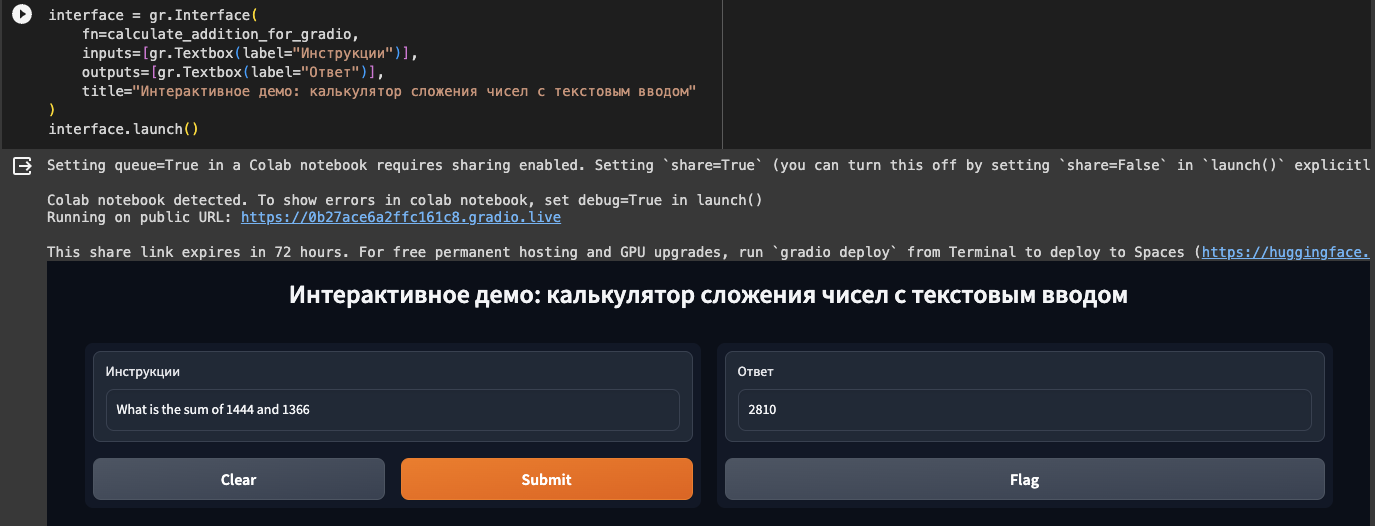

# Выводы

Добработка с помощью Lora даже такой небольшой языковой модели как tinyllama c 15 миллионами параметров, показала очень хороший результат в задаче сложения чисел. Обязательно буду пробовать этот подход с этой моделью в будущих задачах.